In [1]:
import numpy as np
np.random.seed(20020703)
r = 0.05
sigma = 0.5
T = 1
s0 = 100
K = 110
B = 90
N = 10000  # Number of simulations
M = 1000 # Number of time steps
dt = T / M

# simulate GBM paths
def simulate_gbm_paths(s0, r, sigma, T, M, N):
    paths = np.zeros((M + 1, N))
    paths[0] = s0
    for t in range(1, M + 1):
        Z = np.random.standard_normal(N)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

# Calculate the probability of not crossing the barrier
def survival_probability(X_i, X_j, B, h):
    return 1 - np.exp(-2 * (B - X_i) * (B - X_j) / (sigma**2 * h))

# Calculate the payoff with barrier
def barrier_option_payoff(paths, K, B, r, T):
    n = paths.shape[0] - 1
    h = T / n
    payoff = np.zeros(paths.shape[1])
    
    for j in range(paths.shape[1]):
        survival = 1
        for i in range(n):
            X_i = paths[i, j]
            X_j = paths[i + 1, j]
            if X_i < B or X_j < B:
                survival = 0
                break
            p_i = survival_probability(X_i, X_j, B, h)
            U_i = np.random.uniform(0, 1)
            if U_i > p_i:
                survival = 0
                break
        payoff[j] = np.exp(-r * T) * max(paths[-1, j] - K, 0) * survival
    
    return payoff

# Estimate Delta using pathwise sensitivity
def estimate_delta(paths, K, B, r, T):
    n = paths.shape[0] - 1
    h = T / n
    payoff = np.zeros(paths.shape[1])
    delta_sensitivity = np.zeros(paths.shape[1])
    
    for j in range(paths.shape[1]):
        survival = 1
        for i in range(n):
            X_i = paths[i, j]
            X_j = paths[i + 1, j]
            if X_i < B or X_j < B:
                survival = 0
                break
            p_i = survival_probability(X_i, X_j, B, h)
            U_i = np.random.uniform(0, 1)
            if U_i > p_i:
                survival = 0
                break
        payoff[j] = np.exp(-r * T) * max(paths[-1, j] - K, 0) * survival
        if paths[-1, j] > K:
            delta_sensitivity[j] = np.exp(-r * T) * (paths[-1, j] / s0) * survival
    
    delta = np.mean(delta_sensitivity)
    return delta

# Function to estimate Vega using pathwise sensitivity
def estimate_vega(paths, K, B, r, T):
    n = paths.shape[0] - 1
    h = T / n
    payoff = np.zeros(paths.shape[1])
    vega_sensitivity = np.zeros(paths.shape[1])
    
    for j in range(paths.shape[1]):
        survival = 1
        for i in range(n):
            X_i = paths[i, j]
            X_j = paths[i + 1, j]
            if X_i < B or X_j < B:
                survival = 0
                break
            p_i = survival_probability(X_i, X_j, B, h)
            U_i = np.random.uniform(0, 1)
            if U_i > p_i:
                survival = 0
                break
        payoff[j] = np.exp(-r * T) * max(paths[-1, j] - K, 0) * survival
        if paths[-1, j] > K:
            vega_sensitivity[j] = np.exp(-r * T) * (paths[-1, j] * ((np.log(paths[-1, j] / s0) - (r - 0.5 * sigma**2) * T) / sigma - sigma*T)) * survival
    
    vega = np.mean(vega_sensitivity)
    return vega

# Simulate paths
paths = simulate_gbm_paths(s0, r, sigma, T, M, N)
payoff = barrier_option_payoff(paths, K, B, r, T)
option_price = np.mean(payoff)
# Estimate Delta and Vega
delta = estimate_delta(paths, K, B, r, T)
vega = estimate_vega(paths, K, B, r, T)

print(f"Estimated Payoff: {option_price}")
print(f"Estimated Delta: {delta}")
print(f"Estimated Vega: {vega}")

Estimated Payoff: 8.955961871981861
Estimated Delta: 0.23364233964894174
Estimated Vega: 21.225134306303467


In [2]:
def running_mean(data):
    return np.cumsum(data) / np.arange(1, len(data) + 1)

In [3]:
import matplotlib.pyplot as plt

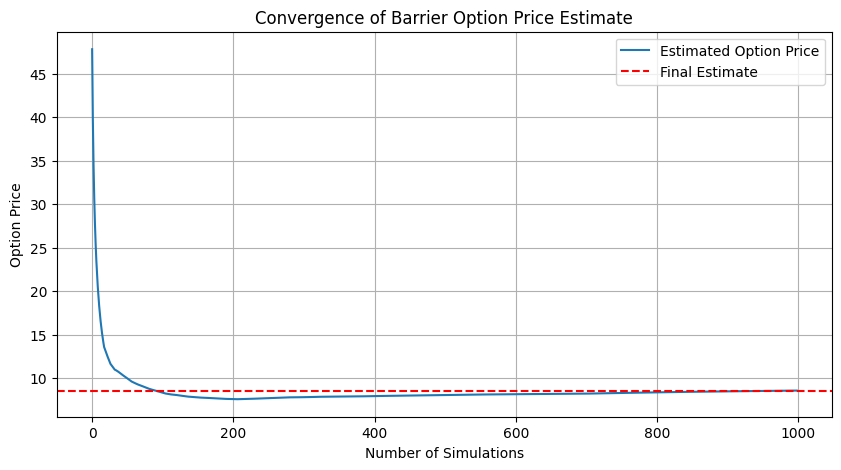

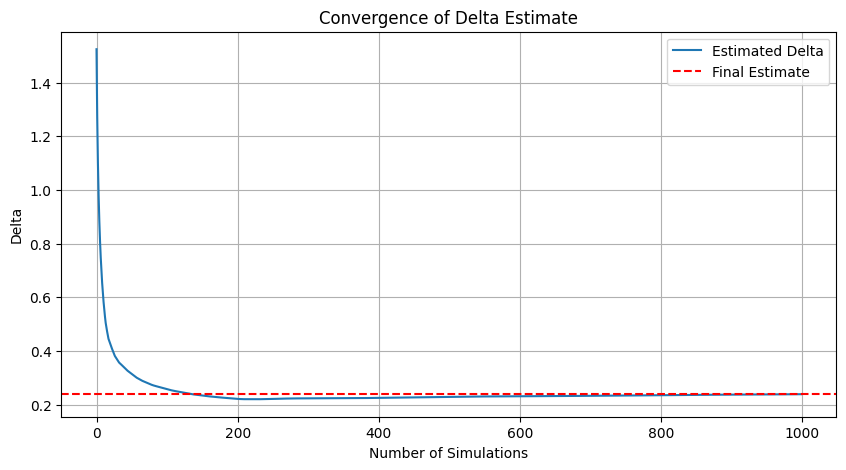

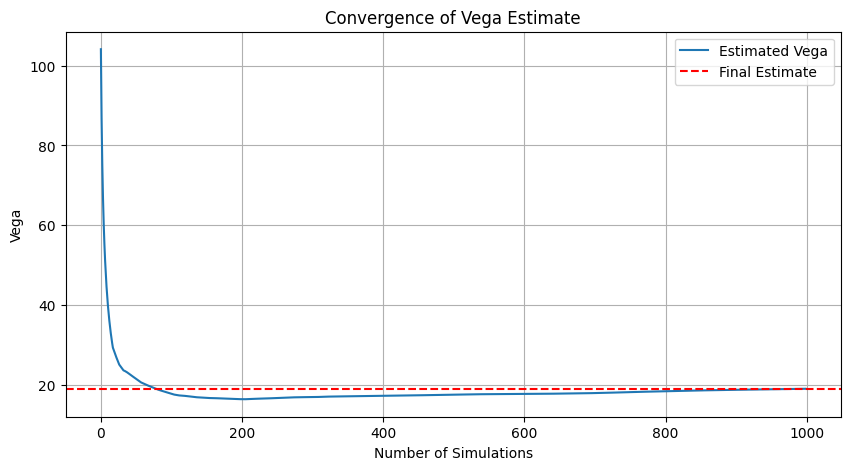

In [4]:
N_simulations = 1000  # Number of simulations to visualize convergence
paths = simulate_gbm_paths(s0, r, sigma, T, M, N_simulations)

# Compute convergence of option price, delta, and vega
option_prices = np.array([np.mean(barrier_option_payoff(paths[:, :i+1], K, B, r, T)) for i in range(1, N_simulations)])
deltas = np.array([estimate_delta(paths[:, :i+1], K, B, r, T) for i in range(1, N_simulations)])
vegas = np.array([estimate_vega(paths[:, :i+1], K, B, r, T) for i in range(1, N_simulations)])

# Running mean to observe convergence
option_prices_running = running_mean(option_prices)
deltas_running = running_mean(deltas)
vegas_running = running_mean(vegas)

# Plot Convergence of Option Price
plt.figure(figsize=(10, 5))
plt.plot(option_prices_running, label="Estimated Option Price")
plt.axhline(y=np.mean(option_prices), color='r', linestyle='--', label="Final Estimate")
plt.xlabel("Number of Simulations")
plt.ylabel("Option Price")
plt.title("Convergence of Barrier Option Price Estimate")
plt.legend()
plt.grid()
plt.show()

# Plot Convergence of Delta
plt.figure(figsize=(10, 5))
plt.plot(deltas_running, label="Estimated Delta")
plt.axhline(y=np.mean(deltas), color='r', linestyle='--', label="Final Estimate")
plt.xlabel("Number of Simulations")
plt.ylabel("Delta")
plt.title("Convergence of Delta Estimate")
plt.legend()
plt.grid()
plt.show()

# Plot Convergence of Vega
plt.figure(figsize=(10, 5))
plt.plot(vegas_running, label="Estimated Vega")
plt.axhline(y=np.mean(vegas), color='r', linestyle='--', label="Final Estimate")
plt.xlabel("Number of Simulations")
plt.ylabel("Vega")
plt.title("Convergence of Vega Estimate")
plt.legend()
plt.grid()
plt.show()